In [13]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
from matplotlib import patches as mpatches
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice


%matplotlib inline

# We will use clustering methods to separate stars in the Pleiades cluster from all stars in this area

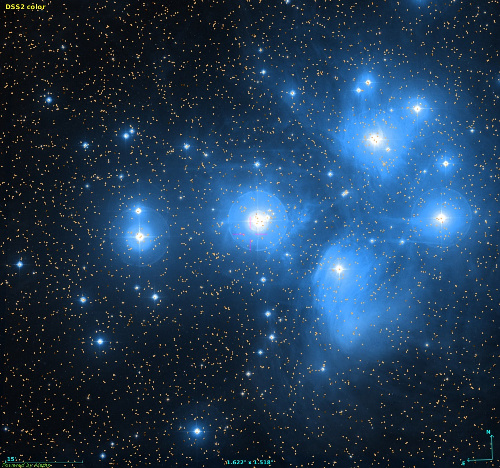

### First, let's load up some Gaia data

In [2]:
data = np.load('Gaia_DR2_sample.npy')

print(data.shape)  # Number of stars
print(data.dtype.names)  # Variables in the array

(10396,)
('source_id', 'ra', 'dec', 'pmra', 'pmdec', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag')


In [90]:
# write csv
fop = open('Gaia_DR2_sample.csv','w')
fop.write('source_id,ra,dec,pmra,pmdec,parallax,parallax_error,phot_g_mean_mag\n')
for i in range(len(data['ra'])):
    fop.write('%d,%.6f,%.6f,'%(data['source_id'][i],data['ra'][i],data['dec'][i])+\
                '%.1f,%.1f,%.1f,%.1f,'%(data['pmra'][i],data['pmdec'][i],data['parallax'][i],data['parallax_error'][i])+\
                '%.1f\n'%(data['phot_g_mean_mag'][i]) )
fop.close()

### Let's look at the data

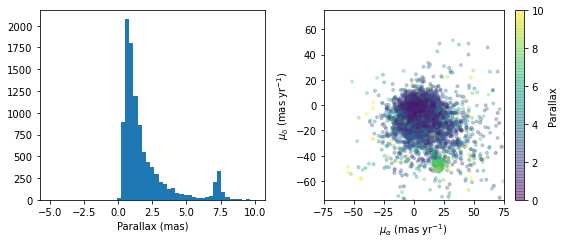

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))


# Parallax
bins = np.linspace(-5, 10, 50)
ax[0].hist(data['parallax'], bins=bins)
ax[0].set_xlabel('Parallax (mas)')


# Proper motion
scat = ax[1].scatter(data['pmra'], data['pmdec'], marker='.', alpha=0.3, \
                     c = data['parallax'], cmap = 'viridis', vmin=0, vmax = 10)
ax[1].set_xlabel(r'$\mu_{\alpha}$ (mas yr$^{-1}$)')
ax[1].set_ylabel(r'$\mu_{\delta}$ (mas yr$^{-1}$)')
ax[1].set_xlim(-75, 75)
ax[1].set_ylim(-75, 75)
cb = plt.colorbar(scat, label = 'Parallax') 

plt.tight_layout()
plt.show()

## The Pleiades cluster stars are all moving with the ~same velocity in space and are at similar distances to each other. We can use this knowledge to classify which stars in our dataset are likely members of this group

### Now, let's identify Pleiades members using one of our clustering algorithms

In [59]:
# Create data array - we want to identify cluster members using parallax and proper motions
X = np.zeros((len(data), 3))

X[:,0] = data['parallax']*10. # Rescale the parallax to add weight 
X[:,1] = data['pmra']
X[:,2] = data['pmdec']

# K-means

Labels assigned:
[1 1 1 ... 1 1 1]
Cluster centers:
[[ 31.99968273  25.48751955 -45.21777112]
 [  7.15935112   3.4575752   -5.77269247]]


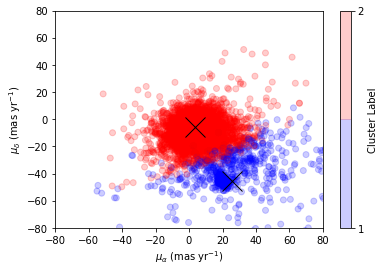

In [69]:
Clusters_kmeans = 2
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d

#eqws = np.column_stack((ewHeII,ewHeI))
kmeans = KMeans(n_clusters=Clusters_kmeans, random_state=0).fit(X)

print ("Labels assigned:")
print (kmeans.labels_)

print ("Cluster centers:")
print (kmeans.cluster_centers_)

cc_x = kmeans.cluster_centers_[:,1]
cc_y = kmeans.cluster_centers_[:,2]

plt.plot(cc_x, cc_y, 'x', ms=20, c='k')

new_map = matplotlib.cm.gray.from_list('whatever', ('blue', 'red'), N=Clusters_kmeans)
#print new_map
scat2 = plt.scatter(X[:,1], X[:,2], c=kmeans.labels_, edgecolors='face', cmap=new_map, alpha = 0.2)
cb = plt.colorbar(scat2, ticks=range(0,Clusters_kmeans+1,1))   # number of clusters
cb.set_ticklabels(range(1,Clusters_kmeans+2,1))
cb.set_label('Cluster Label')
# ax.plot(cc_x, cc_y, 'k+', ms=100)

plt.xlabel(r'$\mu_{\alpha}$ (mas yr$^{-1}$)')
plt.ylabel(r'$\mu_{\delta}$ (mas yr$^{-1}$)')

# Plot range
plt.xlim(-80, 80)
plt.ylim(-80, 80)

plt.show()

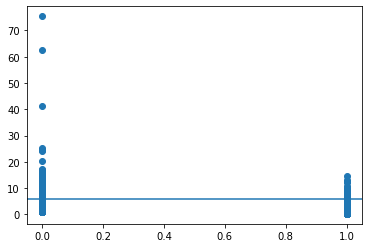

In [66]:
plt.scatter(kmeans.labels_, data['parallax'])
plt.axhline(6)

### DBSCAN

In [62]:

# DBSCAN
model = cluster.DBSCAN(eps=5, min_samples=15)


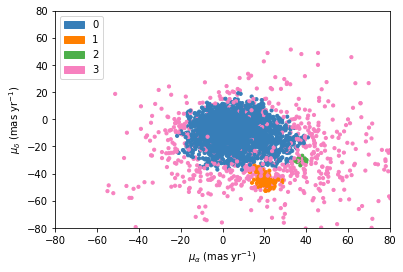

In [65]:
# Fit model
model.fit(X)


# Get classifiers
if hasattr(model, 'labels_'):
    y_pred = model.labels_.astype(np.int)
else:
    y_pred = model.predict(X)


# Add a title to denote which model we ran
#plt.title(model_name, size=14)

# In case some y_pred are negative
y_pred[y_pred == -1] = np.max(y_pred) + 1

# Set a series of colors, so we don't run out
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))


# Plot points
plt.scatter(X[:, 1], X[:, 2], s=10, color=colors[y_pred])


# Plot range
#plt.xlim(-40, 35)
#plt.ylim(-60, 30)
plt.xlim(-80, 80)
plt.ylim(-80, 80)

# Plot labels
plt.xlabel(r'$\mu_{\alpha}$ (mas yr$^{-1}$)')
plt.ylabel(r'$\mu_{\delta}$ (mas yr$^{-1}$)')

# Color labels
patches = []
for i in range(len(np.unique(y_pred))):
    patches.append(mpatches.Patch(color=colors[i], label=str(i)))


plt.legend(handles=patches)


    
plt.show()

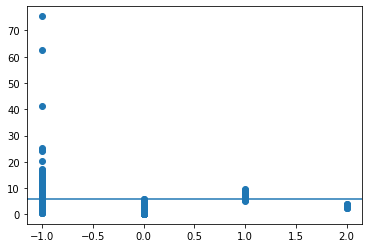

In [68]:
plt.scatter(model.labels_, data['parallax'])
plt.axhline(6)

## If you're bored/wondering 'so what?' read on...

### Stars in clusters are born together from the same cloud, they all have the same age within a few Myrs. We can figure out the age of the cluster by looking at a special kind of diagram shown here (Color-magnitude diagram):

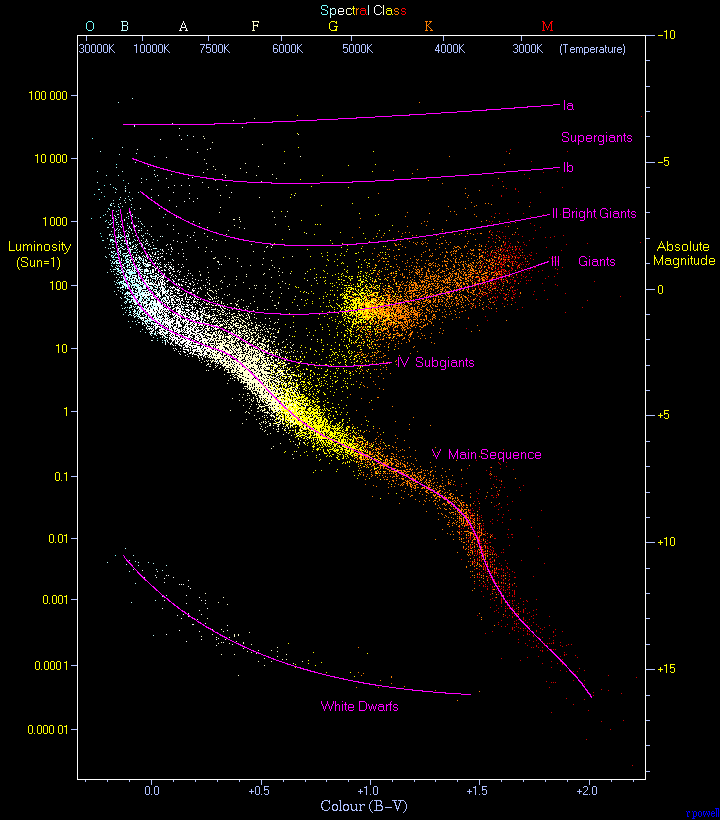

## Next, we will see how to estimate the age of the cluster from the properties of the stars that our Clustering algorithm selected

### Our function to calculate absolute magnitudes

In [6]:
def get_absolute_mag(apparent_magnitude, parallax):
    """ This function calculates the absolute magnitude from the apparent
    magnitude and the astrometric parallax
    
    Arguments
    ---------
    apparent_magnitude : float (mag)
        The apparent magnitude of the star. This can be in any band
        
    parallax : float (mas)
        The astrometric parallax of the star.
        
    Returns
    -------
    absolute_magnitude : float
        The absolute magnitude of the star
    """
    
    absolute_magnitude = apparent_magnitude - 5.0 * np.log10(1.0e2/parallax)
    
    return absolute_magnitude

### Now, let's plot a CMD

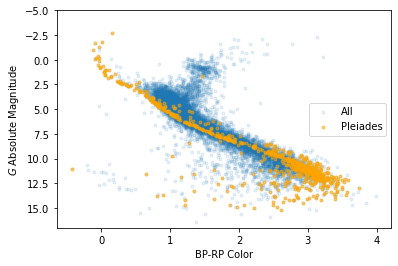

In [104]:
G_abs = get_absolute_mag(data['phot_g_mean_mag'], data['parallax'])
BP_RP_color = data['phot_bp_mean_mag'] - data['phot_rp_mean_mag']

# All stars
plt.scatter(BP_RP_color, G_abs, marker='.', alpha=0.1, label='All')

# All stars of Pleiades
idx = 1
plt.scatter(BP_RP_color[y_pred==idx], G_abs[y_pred==idx], marker='.', alpha=0.5, c='orange', label='Pleiades')

plt.legend()
plt.xlabel('BP-RP Color')
plt.ylabel(r'$G$ Absolute Magnitude')

plt.ylim(17, -5)

plt.show()

## This allows us to tell when this star cluster was born. Let's overlay lines of constant age on this plot:

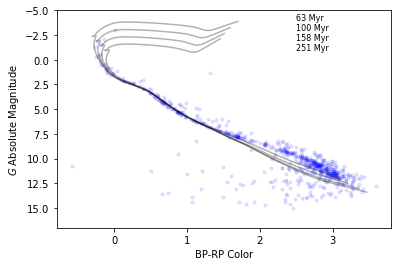

In [102]:
isochrones_Z000 = np.load("./Gaia_bands_young_Z000.npy")


# Extinction and reddening of the Pleiades
A_G = 0.25
A_BP = 0.28
A_RP = 0.13
E_BP_RP = A_BP - A_RP


# Determine absolute magnitude - unextincted
G_abs = get_absolute_mag(data['phot_g_mean_mag'], data['parallax']) - A_G

# Determine color - unreddened
BP_RP_color = data['phot_bp_mean_mag'] - data['phot_rp_mean_mag'] - E_BP_RP


plt.scatter(BP_RP_color[y_pred==idx], G_abs[y_pred==idx], marker='.', alpha=0.1, c='b')

for i, age in enumerate(np.unique(isochrones_Z000['age'])):
    color = isochrones_Z000[isochrones_Z000['age']==age]['Gaia_BP'] - isochrones_Z000[isochrones_Z000['age']==age]['Gaia_RP']
    magnitude = isochrones_Z000[isochrones_Z000['age']==age]['Gaia_G']

    plt.plot(color, magnitude, color='k', alpha=0.3)
    plt.text(2.5, -4.0+i, "%.0f"%10**(age-6.0) + ' Myr', fontsize=8)

    
plt.xlabel('BP-RP Color')
plt.ylabel(r'$G$ Absolute Magnitude')
plt.gca().set_ylim(17, -5)

plt.show()